In [1]:
from src.common.files import get_processed_paths
import zarr
import numpy as np
import matplotlib.pyplot as plt

# Import dimmensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
# Get a sim and a real file
z_sim, z_real = get_processed_paths(
    controller="diffik",
    domain=["sim", "real"],
    task=["one_leg", "one_leg_simple"],
    demo_source="teleop",
    demo_outcome="success",
    randomness=["low", "med"],
    suffix=None,
)

print(z_sim)
print(z_real)

z_sim = zarr.open(z_sim)
z_real = zarr.open(z_real)

/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg/teleop/med/success.zarr
/data/scratch/ankile/furniture-data/processed/diffik/real/one_leg_simple/teleop/low/success.zarr


In [7]:
dim_names = ["x", "y", "z"]

def plot_cross_section(ax, sim, real, dims):
    # Plot the sim data
    d1, d2 = dims
    ax.scatter(sim[:, d1], sim[:, d2], alpha=0.05, c="blue", s=1)
    # Plot the real data
    ax.scatter(real[:, d1], real[:, d2], alpha=0.05, c="red", s=1)

    # Add a legend
    ax.scatter([], [], c="blue", label="sim")
    ax.scatter([], [], c="red", label="real")

    ax.legend()

    ax.set_xlabel(dim_names[dims[0]])
    ax.set_ylabel(dim_names[dims[1]])

Text(0.5, 0.98, 'Cross-sections of the end effector position for sim and real data')

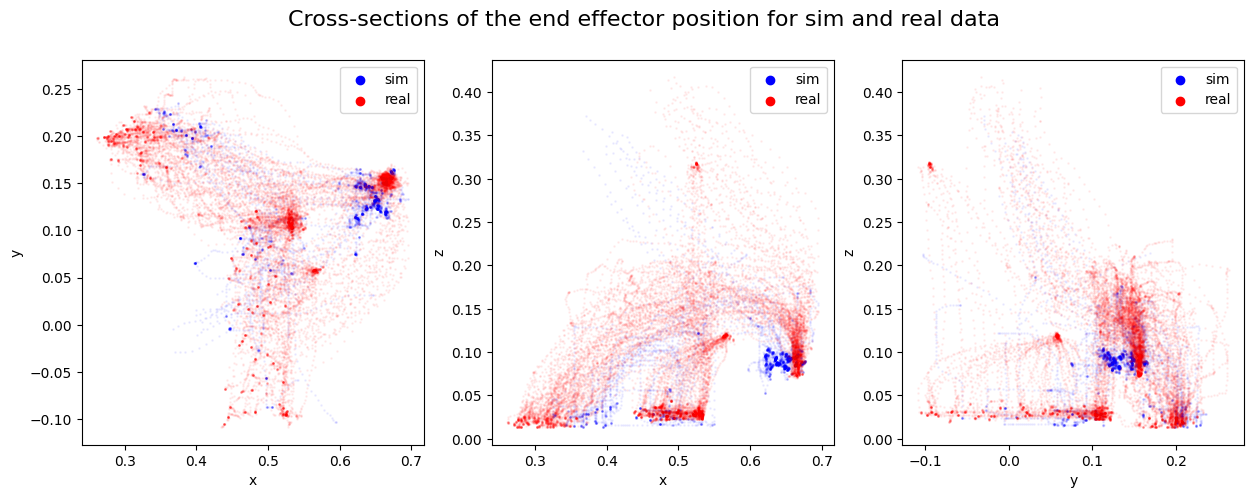

In [9]:
# More simply, plot the 3 cross-section position of the end effector for the sim and real data in one plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sim = z_sim["robot_state"][:]
real = z_real["robot_state"][:]
# real[:, 2] -= 0.04875503  # Correct the z position of the real data

plot_cross_section(axs[0], sim, real, [0, 1])
plot_cross_section(axs[1], sim, real, [0, 2])
plot_cross_section(axs[2], sim, real, [1, 2])

fig.suptitle("Cross-sections of the end effector position for sim and real data", fontsize=16)

In [10]:
# What's the limits in the xyz dimensions for the sim and real data?
print("Sim limits")
print(np.min(sim[:,:3], axis=0))
print(np.max(sim[:,:3], axis=0))

print("Real limits")
print(np.min(real[:,:3], axis=0))
print(np.max(real[:,:3], axis=0))

Sim limits
[ 0.32395905 -0.10266993  0.0137516 ]
[0.69478536 0.23505706 0.37206098]
Real limits
[ 0.2615039  -0.10847677  0.01340746]
[0.6953673  0.26242492 0.41709128]


In [11]:
# Difference between smallest z between sim and real
print("Difference in smallest z")
print(np.min(real[:,2]) - np.min(sim[:,2]))

Difference in smallest z
-0.000344133


In [12]:
def get_and_concat_state_action_space(z):
    robot_state = z["robot_state"][:]
    action = z["action/pos"][:]

    state_action = np.concatenate([robot_state, action], axis=-1)

    return state_action

In [13]:
sa_sim = get_and_concat_state_action_space(z_sim)[:, :3]
sa_real = get_and_concat_state_action_space(z_real)[:, :3]

sa = np.concatenate([sa_sim, sa_real], axis=0)
source_domain = np.concatenate([np.zeros(sa_sim.shape[0]), np.ones(sa_real.shape[0])])

print(sa_sim.shape, sa_real.shape)

(4806, 3) (15398, 3)


In [14]:
# Perform PCA and t-SNE and plot the results so we can compare the state action spaces of the sim and real data in the same space
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca_result = pca.fit_transform(sa)
tsne_result = tsne.fit_transform(sa)

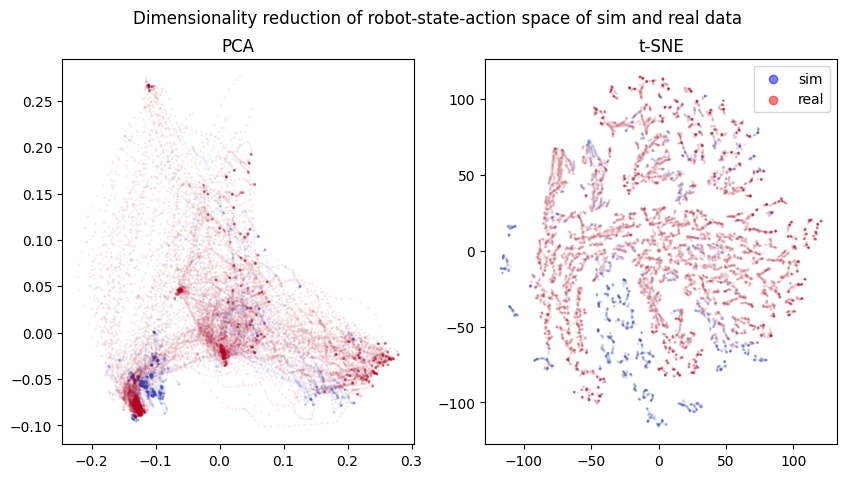

In [15]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=source_domain, cmap="coolwarm", alpha=0.05, s=1)
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=source_domain, cmap="coolwarm", alpha=0.05, s=1)
plt.title("t-SNE")

# Add a legend
plt.scatter([], [], c="blue", label="sim", alpha=0.5)
plt.scatter([], [], c="red", label="real", alpha=0.5)
plt.legend()

# Add a title
plt.suptitle("Dimensionality reduction of robot-state-action space of sim and real data")

plt.show()

Text(0.5, 1.0, 'PCA component 2')

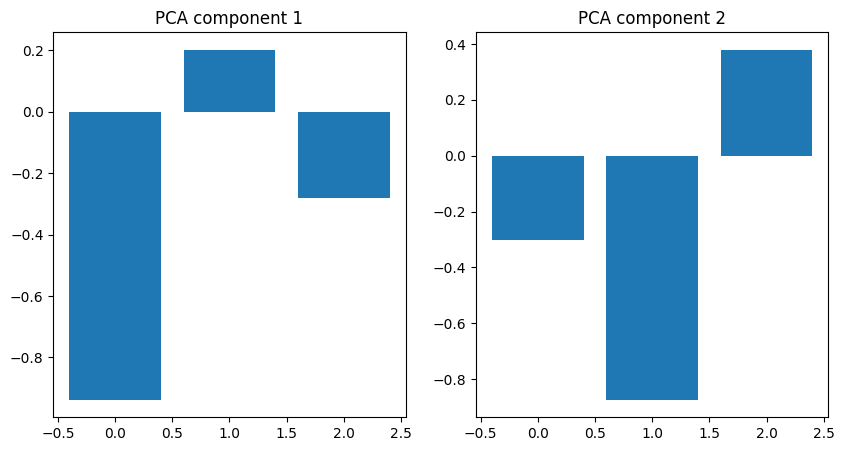

In [16]:
# Show what input features are most important for the PCA in one plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(range(len(pca.components_[0])), pca.components_[0])
axs[0].set_title("PCA component 1")

axs[1].bar(range(len(pca.components_[1])), pca.components_[1])
axs[1].set_title("PCA component 2")

In [17]:
# Perform PCA and t-SNE and plot the results so we can compare the state action spaces of the sim and real data in the same space
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca.fit(sa_real)
# tsne.fit(sa_real)

pca_result = pca.transform(sa)
# tsne_result = tsne.transform(sa)


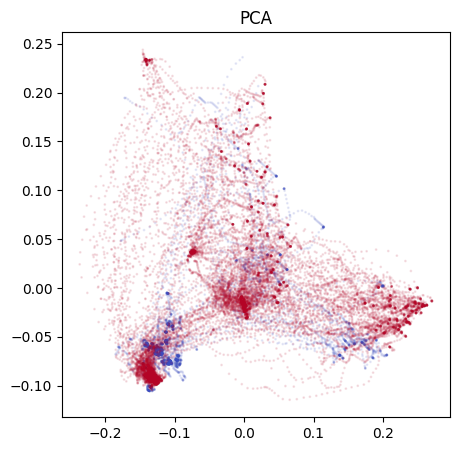

In [31]:

plt.figure(figsize=(5, 5))

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=source_domain, cmap="coolwarm", alpha=0.1, s=1)
plt.title("PCA")


plt.show()

### Compare histograms over the action magnitudes

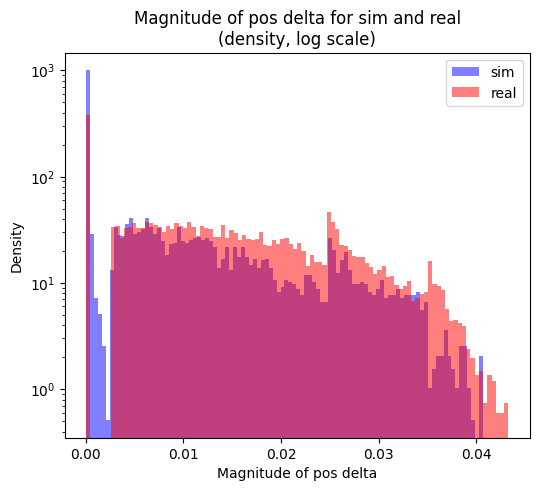

In [29]:
delta_sim = sim = z_sim["action/delta"][:, :3]
delta_real = sim = z_real["action/delta"][:, :3]

delta_sim_mag = np.linalg.norm(delta_sim, axis=-1)
delta_real_mag = np.linalg.norm(delta_real, axis=-1)

plt.figure(figsize=(6, 5))

plt.hist(delta_sim_mag, bins=100, alpha=0.5, color="blue", label="sim", density=True, log=True)
plt.hist(delta_real_mag, bins=100, alpha=0.5, color="red", label="real", density=True, log=True)

plt.title("Magnitude of pos delta for sim and real\n(density, log scale)")
plt.xlabel("Magnitude of pos delta")
plt.ylabel("Density")

plt.legend()